# Using the produced models

In [1]:
# import sys
# sys.path.append('..')
from pytorch_utils import *
from lightning_utils import *
from pytorch_vision_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
data_path = r'E:\Data_and_Models\Kaggle_Cards'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Reconstructing the models

Timings (on GTX 970) and last-epoch (therefore not necessarily best) loss and F1:

| **Model** | **Retrained Portion** | **Epochs** | **Time** | **Epoch Time** | **train_loss** | **train_metric** | **test_loss** | **test_metric** |
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| **EfficientNet B0** | Classification | 10 | 7:43 | 0:25 | 1.4660 | 0.5907 | 1.8822 | 0.4228 |
| **EfficientNet B2** | Classification | 10 | 21:50 | 2:11 | 1.4443 | 0.6009 | 1.8505 | 0.4279 |
| **RexNet 1.0** | Classification | 10 | 7:21 | 0:44 | 1.5509 | 0.5605 | 2.0055 | 0.4186 |
| **RexNet 1.5** | Classification | 10 | 8:00 | 0:48 | 0.8666 | 0.7560 | 1.5839 | 0.4884 |
| **RexNet 1.0** | Full Retrain | 10 | 30:49 | 3:04 | 0.0903 | 0.9732 | 0.2218 | 0.9390 |
| **RexNet 1.0** | Full Retrain | val_loss early stop at 5 (equalling 2)| 16:32 | 2:40 | 0.2707 | 0.8750 | 0.0996 | 1 |
| **RexNet 1.0** | Classification | val_loss early stop but all 10 (7 selected) | 6:55 | 0:38 | 2.564 | 0.1250 | 2.9857 | 0.2222 |
| **RexNet 1.0 features -> LightGBM** | No retraining; feature extraction -> GB | 50 bagging gbdt iterations (OpenCL, not CUDA) | 1:08 | 1:53 to extract train and validation features |  |  |  | 0.4188 |
| **RexNet 1.0 features -> LightGBM** | No retraining; feature extraction -> GB | 100 bagging gbdt iterations (OpenCL, not CUDA) | 2:40 | 1:53 to extract train and validation features |  |  |  | 0.4679 |
| **RexNet 1.5 features -> LightGBM** | No retraining; feature extraction -> GB | 100 bagging gbdt iterations (OpenCL, not CUDA) | 3:37 | 1:50 to extract train and validation features |  |  |  | 0.5433 |

In [3]:
# Recreate the model and load the saved parameters

classes = [os.path.basename(p) for p in Path(fr'{data_path}\test').glob('*')]

experiment_name = ''

# # EfficientNet B0
# model_name, extra = 'EffNetB0', '0_First_Adam001_10_epochs'
# model = tv.models.efficientnet_b0(weights = (weights := tv.models.EfficientNet_B0_Weights.DEFAULT)).to(device)
# transforms = weights.transforms()
# for param in model.features.parameters(): param.requires_grad = False
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p = 0.2, inplace = True),
#     torch.nn.Linear(in_features = 1280, out_features = len(classes), bias = True)
# ).to(device)

# # EfficientNet B2
# model_name, extra = 'EffNetB2', '0_First_Adam001_10_epochs'
# model = tv.models.efficientnet_b0(weights = (weights := tv.models.EfficientNet_B2_Weights.DEFAULT)).to(device)
# transforms = weights.transforms()
# for param in model.features.parameters(): param.requires_grad = False
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p = 0.3, inplace = True),
#     torch.nn.Linear(in_features = 1408, out_features = len(classes), bias = True)
# ).to(device)

# RexNet 1.0
# model_name, extra = 'RexNet10', '0_First_Adam001_10_epochs'
experiment_name, model_name, extra = 'FullRetrain_EarlyStop', 'RexNet10', 'Adam001_max10_epochs'
# experiment_name, model_name, extra = 'ClassRetrain_EarlyStop', 'RexNet10', 'Adam001_max10_epochs'
model = timm.create_model('rexnet_100.nav_in1k', pretrained = True, num_classes = 53).eval().to(device)
transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)
for param in model.features.parameters(): param.requires_grad = False
for param in model.stem.parameters(): param.requires_grad = False

# # RexNet 1.5
# model_name, extra = 'RexNet15', '0_First_Adam001_10_epochs'
# model = timm.create_model('rexnet_150.nav_in1k', pretrained = True, num_classes = 53).eval().to(device)
# transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)
# for param in model.features.parameters(): param.requires_grad = False
# for param in model.stem.parameters(): param.requires_grad = False

# model.classifier
model.load_state_dict(torch.load(fr'{data_path}\Models\{experiment_name}_{model_name}_{extra}.pth'))

<All keys matched successfully>

### PyTorch Lightning Models (can just import as non-lightning above though)

In [33]:
experiment_name, model_name, extra = 'FullRetrain_EarlyStop', 'RexNet10', 'Adam001_max10_epochs'
# experiment_name, model_name, extra = 'ClassRetrain_EarlyStop', 'RexNet10', 'Adam001_max10_epochs'

model = timm.create_model('rexnet_100.nav_in1k', pretrained = True, num_classes = 53).eval()
# for param in model.features.parameters(): param.requires_grad = False
# for param in model.stem.parameters(): param.requires_grad = False

transforms = timm.data.create_transform(**timm.data.resolve_model_data_config(model), is_training = False)

loss_fn = nn.CrossEntropyLoss()

# Define an extra metric beside the loss
f1_fn = torchmetrics.F1Score(task = 'multiclass', num_classes = 53)
accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes = 53)

# Individual prediction input pipeline (though better through automated batches)
# with torch.inference_mode(): pred_logit = model(transforms(img).unsqueeze(dim = 0).to(device)) # Prepend "batch" dimension (-> [batch_size, color_channels, height, width])

def prediction_fn(logits): return torch.argmax(torch.softmax(logits, dim = 1), dim = 1)


## The two below imports are for .pth vs .ckpt saved files;
##  in both cases the parameters are only required for the definition and are not actually used
## Again, though, there is no real need to import a pth into the Lightning-wrapped (i.e. Strike) version of the model,
##  as .load_state dict on the wrapped model type works just fine

# # .pth
# model = Strike(model, loss_fn = loss_fn, metric_name_and_fn = ('F1', f1_fn),
#                optimiser_factory = lambda m: torch.optim.Adam(m.parameters(), lr = m.learning_rate),
#                prediction_fn = prediction_fn, learning_rate = 0.001, log_at_every_step = False)
# state_dict = torch.load(fr'{data_path}\Models\{experiment_name}_{model_name}_{extra}.pth')
# model.load_state_dict(state_dict)

# .ckpt
# Need to give arguments again since many are non-pickleable with .save_hyperparameters
#   Could solve by moving those ones to a function producing the class
model = Strike.load_from_checkpoint(fr'{data_path}\Models\{experiment_name}_{model_name}_{extra}.ckpt',
    model = model, loss_fn = loss_fn, metric_name_and_fn = ('F1', f1_fn),
    optimiser_factory = lambda m: torch.optim.Adam(m.parameters(), lr = m.learning_rate),
    prediction_fn = prediction_fn, learning_rate = 0.001, log_at_every_step = False)

In [4]:
summ(model, input_size = (32, 3, 224, 224))

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
RexNet (RexNet)                               [32, 3, 224, 224]    [32, 53]             --                   Partial
├─ConvNormAct (stem)                          [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (bn)                    [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                        [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (features)                       [32, 32, 112, 112]   [32, 1280, 7, 7]     --                   False
│    └─LinearBottleneck (0)                   [32, 32, 112, 112]   [32, 16, 112,

## Predictions

In [9]:
image_paths = list(Path(fr'{data_path}\test').glob('*/*.jpg'))

image_df = record_image_preds(image_paths = image_paths, model = model, transform = transforms, class_names = classes)
image_df

  0%|          | 0/265 [00:00<?, ?it/s]

,path,true_class,pred_class,pred_prob,correct
189,E:\Data_and_Models\Kaggle_Cards\test\six of cl...,six of clubs,three of clubs,0.852508,False
112,E:\Data_and_Models\Kaggle_Cards\test\king of d...,king of diamonds,queen of diamonds,0.711170,False
167,E:\Data_and_Models\Kaggle_Cards\test\seven of ...,seven of clubs,five of clubs,0.691422,False
153,E:\Data_and_Models\Kaggle_Cards\test\queen of ...,queen of diamonds,six of diamonds,0.667886,False
2,E:\Data_and_Models\Kaggle_Cards\test\ace of cl...,ace of clubs,two of clubs,0.582781,False
...,...,...,...,...,...
194,E:\Data_and_Models\Kaggle_Cards\test\six of di...,six of diamonds,six of diamonds,0.562002,True
195,E:\Data_and_Models\Kaggle_Cards\test\six of he...,six of hearts,six of hearts,0.408652,True
97,E:\Data_and_Models\Kaggle_Cards\test\jack of s...,jack of spades,jack of spades,0.376405,True
148,E:\Data_and_Models\Kaggle_Cards\test\queen of ...,queen of clubs,queen of clubs,0.319073,True


#### Random sample

alt.VConcatChart(...)
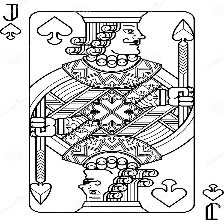
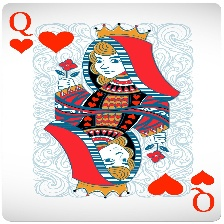
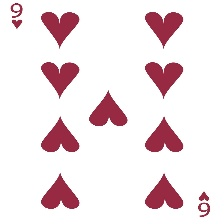
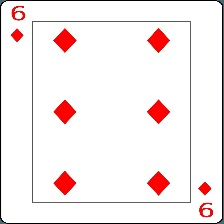
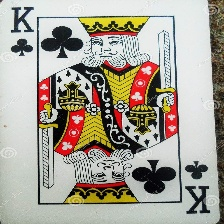
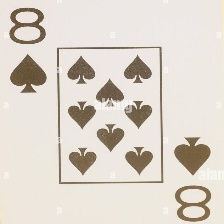
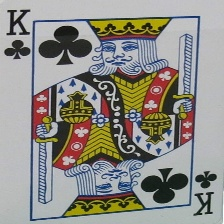
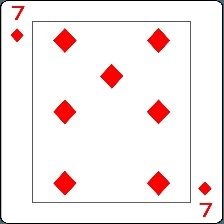
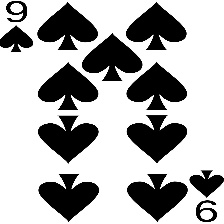
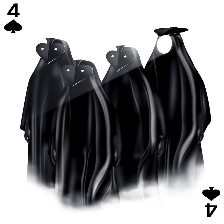
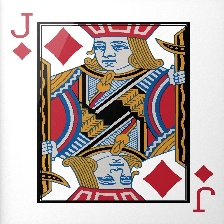
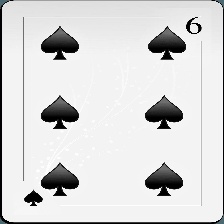

In [10]:
image_pred_grid(image_df.sample(12).copy(), ncols = 6, img_width = 200, img_height = 200, allow_1_col_reduction = True)

#### Most-wrong predictions

alt.VConcatChart(...)
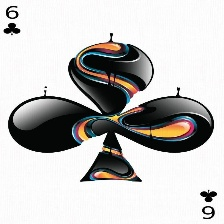
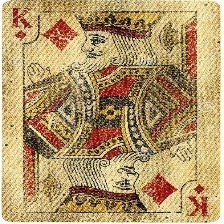
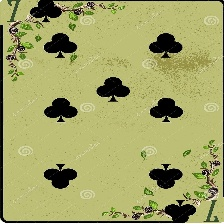
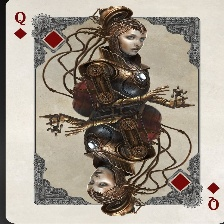
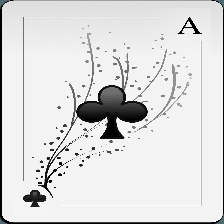
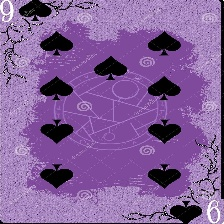
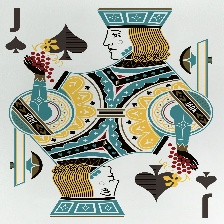
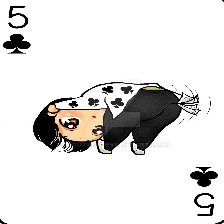
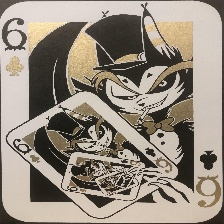
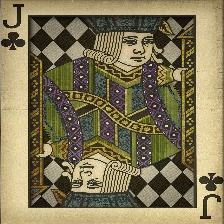
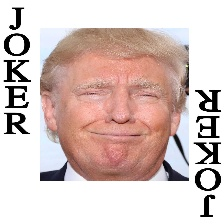
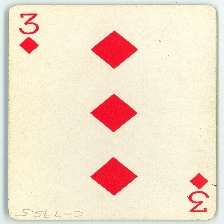

In [11]:
image_pred_grid(image_df.head(12).copy(), ncols = 6, img_width = 200, img_height = 200, allow_1_col_reduction = True)